### Cloning our github repository to get the required files for Mask R-CNN and 3D reconstruction.

In [ ]:
!git clone https://github.com/shivankar-p/pothole.git

Cloning into 'pothole'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 344 (delta 26), reused 5 (delta 2), pack-reused 288
Receiving objects: 100% (344/344), 291.05 MiB | 17.64 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Updating files: 100% (127/127), done.


###Installing Metashape from the wheel package

In [ ]:
#installing metashape api
!wget https://s3-eu-west-1.amazonaws.com/download.agisoft.com/Metashape-2.0.0-cp35.cp36.cp37.cp38-abi3-linux_x86_64.whl

--2023-01-21 17:02:23--  https://s3-eu-west-1.amazonaws.com/download.agisoft.com/Metashape-2.0.0-cp35.cp36.cp37.cp38-abi3-linux_x86_64.whl
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.25.35, 52.92.1.16, 52.218.97.59, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.25.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49944815 (48M) [binary/octet-stream]
Saving to: ‘Metashape-2.0.0-cp35.cp36.cp37.cp38-abi3-linux_x86_64.whl’

Metashape-2.0.0-cp3 100%[===================>]  47.63M  11.0MB/s    in 5.0s    

2023-01-21 17:02:29 (9.59 MB/s) - ‘Metashape-2.0.0-cp35.cp36.cp37.cp38-abi3-linux_x86_64.whl’ saved [49944815/49944815]



In [ ]:
!python3 -m pip install Metashape-2.0.0-cp35.cp36.cp37.cp38-abi3-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./Metashape-2.0.0-cp35.cp36.cp37.cp38-abi3-linux_x86_64.whl
Metashape is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


###Installing dependencies

In [ ]:
%cd pothole/src
!pip install -r requirements.txt
!ls

/content/pothole/src/pothole/src
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
_3D_reconstruction  estimators	 mask_rcnn.egg-info   requirements.txt
batch.py	    Images	 models		      result.png
build		    LICENSE	 mrcnn		      setup.cfg
custom.py	    MANIFEST.in  pothole_classes.txt  Videos
dist		    mask.py	 __pycache__


### Downloading model

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#downloading model
!mkdir models
%cd models
!gdown https://drive.google.com/uc?id=17IY3CnSz7AaIXwE7Q8RSkAV4_6UPiO6-&confirm=t&uuid=91ba32c4-e5a6-4e3b-99f7-bd2162c0e9b7&at=ACjLJWlF0hOpJDIGIBmsaArqm9Yn:1674221046474

mkdir: cannot create directory ‘models’: File exists
/content/pothole/src/pothole/src/models
Downloading...
From: https://drive.google.com/uc?id=17IY3CnSz7AaIXwE7Q8RSkAV4_6UPiO6-
To: /content/pothole/src/pothole/src/models/mask_rcnn_model.h5
100% 256M/256M [00:02<00:00, 108MB/s] 


In [ ]:
%cd ../
#!python3 mask8.py --image Images/frame39.png

/content/pothole/src/pothole/src


### Importing required python modules

In [ ]:
import os
import cv2
import numpy as np
import random
import colorsys
import argparse
import time
from mrcnn import model as modellib
from mrcnn import visualize
import matplotlib
from custom import CustomConfig
import tensorflow as tf
import time
from estimators import depth_estimator
from _3D_reconstruction import coordinates
from random import sample
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


### Initializing model and loading the weights

In [ ]:
def prepare_mrcnn_model(model_path, model_name, class_names, my_config):
    classes = open(class_names).read().strip().split("\n")
    print("No. of classes", len(classes))

    hsv = [(i / len(classes), 1, 1.0) for i in range(len(classes))]
    COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.seed(42)
    random.shuffle(COLORS)

    #["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask", "rpn_model"]
    #initialises the model and loads it with the weights
    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=my_config)
    model.load_weights(model_name, by_name=True)

    return COLORS, model, classes

### Creating a dense point cloud

In [ ]:
# %cd _3D_reconstruction
# !python3 main.py
#%cd ../

### Model inference and Severity Estimation

In [ ]:
def custom_visualize(test_image, model, colors, classes, draw_bbox, mrcnn_visualize, instance_segmentation, frame_no,
                                                                                     sampling_rate):
    start = time.time()
    #print(colors)
    detections = model.detect([test_image], verbose=1)[0]
    end = time.time()

    print("Time taken to detect: " +  str(end-start))

    if mrcnn_visualize:
        matplotlib.use('TkAgg')
        out = visualize.display_instances(test_image, detections['rois'], detections['masks'], detections['class_ids'],
                                    classes,
                                    detections['scores'])
        print("returning out")
        return out

    if instance_segmentation:
        hsv = [(i / len(detections['rois']), 1, 1.0) for i in range(len(detections['rois']))]
        colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
        random.seed(42)
        random.shuffle(colors)

    pothole_depths = []
    surface_areas = []
    severity_labels = []
    mask_colours = []

    #iterates over no of potholes 
    for i in range(0, detections["rois"].shape[0]):
        (startY, startX, endY, endX) = detections["rois"][i]
        bounding_box = []
        bb_endpoints = [[startX, startY], [endX, startY], [startX, endY], [endX, endY]]
        pothole_depth = 0
        classID = detections["class_ids"][i]

        mask = detections["masks"][:, :, i]
        pixel_arr = np.argwhere(mask == True)
        
        if instance_segmentation:
            color = colors[i][::-1]
        else:
            color = colors[classID][::-1]

        # To visualize the pixel-wise mask of the object
        
        depth_start = time.time()
        arr = np.argwhere(mask == -1)
        num_rows_in_sample = int(arr.shape[0] * sampling_rate)
        
        #sampling points from the masked pothole points
        for point in arr[np.random.choice(arr.shape[0], num_rows_in_sample, replace=False)]:
            projection = coordinates.get_coordinate(frame_no, point[1], point[0])
            if projection is not None:
                pothole_depth = min(pothole_depth, projection[1])
        

        #gives depth of road surrounding the pothole
        ref_depth = depth_estimator.get_ref_depth(bounding_box, frame_no)
        
        
        per_area = pixel_arr.shape[0] * 100 / (mask.shape[0] * mask.shape[1])


        mask_colour, depth, severity_label = depth_estimator.severity_estimator(per_area)

        #(r, g, b) = mask_colour
        test_image = visualize.apply_mask(test_image, mask, mask_colour, alpha=0.5)

        #difference between surrounding depth and pothole depth gives actual pothole depth
        pothole_depths.append(depth-ref_depth)
        surface_areas.append(pixel_arr.shape[0])
        severity_labels.append(severity_label)
        mask_colours.append(mask_colour)


    test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
    
    #annotating the image with bounding box and severity lable
    if draw_bbox == True:
        #print("inside bboc")
        for i in range(0, len(detections["scores"])):
            (startY, startX, endY, endX) = detections["rois"][i]

            classID = detections["class_ids"][i]
            score = pothole_depths[i]
            label = 'Severity'
            final_color = mask_colours[i]
            boundary_color = [final_color[2], final_color[1], final_color[0]]
            text_color = [0, 0, 0]
            
            severity_label = severity_labels[i]


            cv2.rectangle(test_image, (startX, startY), (endX, endY), boundary_color, 2)
            text = "{}: {}".format(label, severity_label)
            if (score > 0):
                 text = "{}: {} Depth: {} cm".format(label, severity_label, round(score, 2))
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(test_image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)

    return test_image

### Reads video frame by frame and performs inference

In [ ]:
def perform_inference_video(use_camera, video_path, model, colors, classes, draw_bbox, mrcnn_visualize,
                            instance_segmentation, save_enable, sampling_rate, out_path):
    if use_camera:
        video = cv2.VideoCapture(0)
        time.sleep(2.0)
    else:
        video = cv2.VideoCapture(video_path)

    video_flag = True
    
    cnt = 0
    
    while True:
        ret, frame = video.read()

        cnt += 1

        if(cnt % 12 != 0):
            continue
        
        
        
        if save_enable and video_flag:
            print("writing video to the :" + out_path)
            out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'MP4V'), 3,
                                  (frame.shape[1], frame.shape[0]))
            video_flag = False

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        output = custom_visualize(frame, model, colors, classes, draw_bbox, mrcnn_visualize, instance_segmentation, cnt, sampling_rate)

        display_img = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
        
        print('\n\n*******************masked_frame***********************\n\n')
        fig = plt.figure()
        fig.set_figwidth(15)
        fig.set_figheight(10)
        plt.imshow(display_img)
        plt.show()

        if save_enable:
            out.write(output)
        
        

        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

### Function for performing inference on image

In [ ]:
def perform_inference_image(image_path, model, colors, classes, draw_bbox, mrcnn_visualize, instance_segmentation,
                            save_enable, sampling_rate):
    test_image = cv2.imread(image_path)
    test_img = test_image
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    

    output = custom_visualize(test_image, model, colors, classes, draw_bbox, mrcnn_visualize, instance_segmentation, 0, sampling_rate)
    display_img = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
    if not mrcnn_visualize:
        if save_enable:
            cv2.imwrite("result.png", output)
    print('\n\n*******************original_image***********************\n\n')
    fig2 = plt.figure()
    fig2.set_figwidth(15)
    fig2.set_figheight(10)
    plt.imshow(test_img)
    plt.show()
        
    print('\n\n*******************masked_image***********************\n\n')
    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(10)
    plt.imshow(display_img)
    plt.show()
        

### Define configs for custom execution for images



**Assigning graphics card defaults**

In [ ]:
class InferenceConfig(CustomConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

# **Selecting image to process**
**Only change the line below to set the needed image path**

In [ ]:
image_path = "Images/frame39.png"

**Tuning model for the given frame**

In [ ]:
Image_config = {'model_name': 'models/mask_rcnn_model.h5',
                'model_path': 'models',
                'class_names': 'pothole_classes.txt',
                'image_path': image_path,
                'instance_segmentation': True,
                'sampling_rate' : 0.01
               }

In [ ]:
%ls

_3D_reconstruction/  estimators/  mask_rcnn.egg-info/  requirements.txt
batch.py             Images/      models/              result.png
build/               LICENSE      mrcnn/               setup.cfg
custom.py            MANIFEST.in  pothole_classes.txt  Videos/
dist/                mask.py      __pycache__/


### Running inference model for images


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

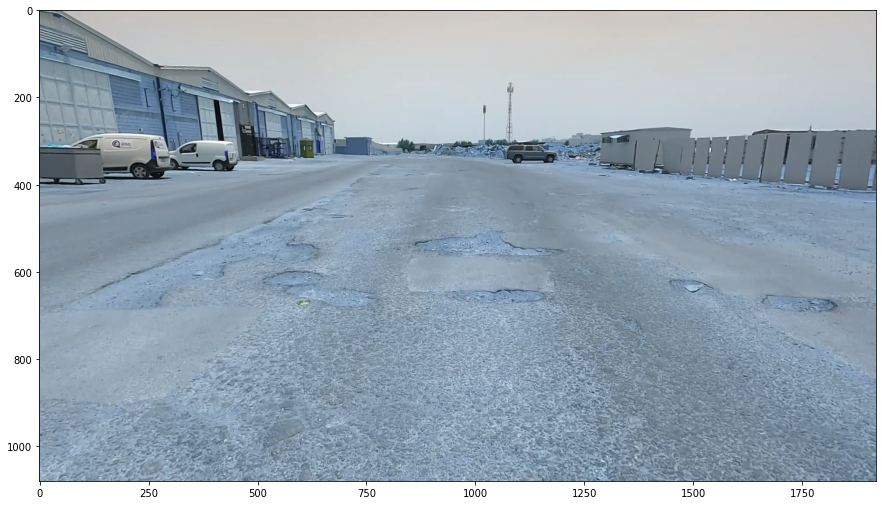



*******************masked_image***********************




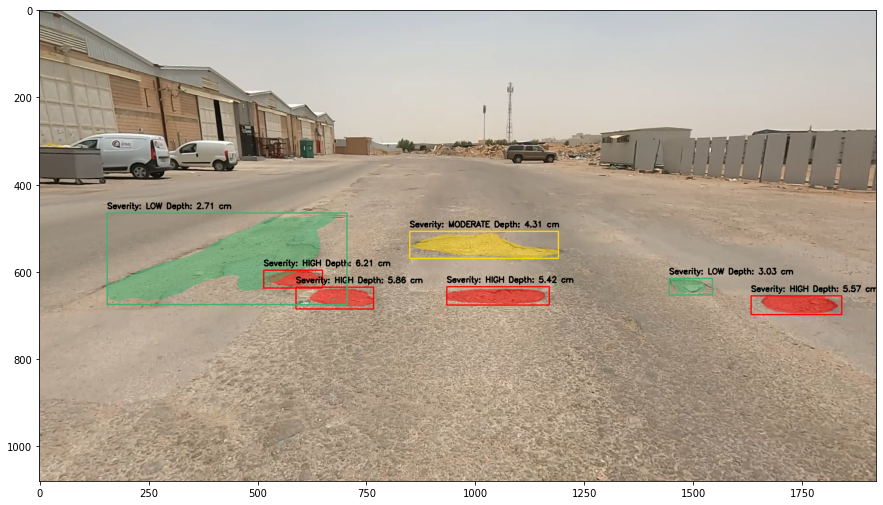

In [ ]:
model_config = InferenceConfig()
model_config.display()
colors, model, classes = prepare_mrcnn_model(Image_config['model_path'], Image_config['model_name'], Image_config['class_names'],
                                                     model_config)
perform_inference_image(Image_config['image_path'], model, colors, classes, True , False,
                                          Image_config['instance_segmentation'], True, Image_config['sampling_rate'])

### Defining configs for custom execution for videos

# **Selecting video to process**
**Only change the line below to set the needed video path**

In [ ]:
video_path = "Videos/Scene1sample1.mp4"

**Tuning model for the given video**

In [ ]:
Video_config = {'model_name': 'models/mask_rcnn_model.h5',
                'model_path': 'models',
                'class_names': 'pothole_classes.txt',
                'video_path': video_path,
                'instance_segmentation': True,
                'sampling_rate' : 0.01,
                'output_path' : 'model_output.mp4'
               }

### Instantiating configs to start execution

In [ ]:
model_config = InferenceConfig()
model_config.display()
colors, model, classes = prepare_mrcnn_model(Video_config['model_path'], Video_config['model_name'], Video_config['class_names'],
                                                     model_config)


### Execute inference model

In [ ]:
perform_inference_video(False, Video_config['video_path'], model, colors, classes, True , False,
                                          Video_config['instance_segmentation'], True, Video_config['sampling_rate'],
                                          Video_config['output_path'])

## Team ApexCoders
- [Shivankar Pilligundla](https://www.linkedin.com/in/shivankar-pilligundla-a1112a201/)
- [Srinivas Manda](https://www.linkedin.com/in/srinivas-manda-41a302224/)
- [Hardik Khandelwal](https://www.linkedin.com/in/hardik-khandelwal-533599205/)
- [Karanjit Saha](https://www.linkedin.com/in/karanjit-saha-65a02122b/)
- [Netradeepak Chinchwadkar](https://www.linkedin.com/in/netradeepak-chinchwadkar-30728a201/)
- [Abhinav Mahajan](https://www.linkedin.com/in/abhinav-mahajan-727068233/)
